<a href="https://colab.research.google.com/github/alracey/level4-project/blob/Higher-dimensions/piecewise_linear_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cu126'

This section defines the target function f, the piecewise transform g, and the transformed function h.

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1000, 1000])


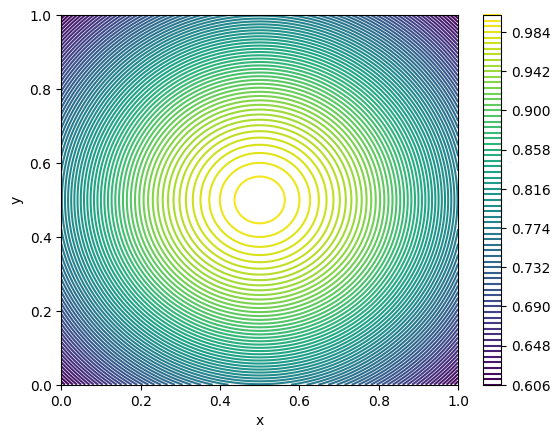

In [2]:
def f(x, y):
  return torch.exp(-((x-0.5)**2 + (y-0.5)**2))

xs, ys = torch.linspace(0, 1, 1000), torch.linspace(0, 1, 1000)

X, Y = torch.meshgrid(xs, ys)
Z = f(X, Y)
print(Z.shape)
plt.figure()
plt.contour(X, Y, Z, levels=75, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
#variance test, should be same as Wolfram Alpha
var = torch.var(Z)
print(var)

tensor(0.0077)


In [4]:
def g(x, params):   #piecewise linear transform with K bins; independent in x,y for now

  #x has shape (2, n) and params has shape (2, K-1) where n is variable

  #bins
  K = len(params[0]) + 1

  #using given params, append 0 and 1 to the ends
  one_d_bins = torch.linspace(0, 1, K+1)
  bins = torch.stack((one_d_bins, one_d_bins), dim=0)

  zeros = torch.zeros((params.size(0), 1))
  ones = torch.ones((params.size(0), 1))
  y = torch.cat([zeros, params, ones], dim=1)

  #find the correct bin indices i for each x value
  i_values = torch.clamp((x * K).long(), max=K-1)   #this is now (2, n)

  # Create row indices as not working in 1D
  row_indices = torch.arange(params.size(0)).unsqueeze(1)

  #compute the edges
  x_left = bins[row_indices, i_values]
  x_right = bins[row_indices, i_values+1]
  y_left = y[row_indices, i_values]
  y_right = y[row_indices, i_values+1]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

#testing

x = torch.linspace(0, 1, 1000)
xs = torch.stack((x, x), dim=0)
params = torch.tensor([[0.2, 0.3, 0.5, 0.6, 0.8],
                      [0.1, 0.2, 0.4, 0.5, 0.7]])
test = g(xs, params)
print(test.shape)



torch.Size([2, 1000])


In [5]:
def h(y, params):   #transformed function in accordance with change of variables formula

  #bins
  K = len(params[0]) + 1

  #using given params, append 0 and 1 to the ends
  one_d_bins = torch.linspace(0, 1, K+1)
  bins = torch.stack((one_d_bins, one_d_bins), dim=0)

  zeros = torch.zeros((params.size(0), 1))
  ones = torch.ones((params.size(0), 1))
  ys = torch.cat([zeros, params, ones], dim=1)

  #find the correct indices
  j_values = torch.clamp((torch.searchsorted(ys, y) - 1), 0, K-1)
  row_indices = torch.arange(params.size(0)).unsqueeze(1)

  #compute the edges
  x_left = bins[row_indices, j_values]
  x_right = bins[row_indices, j_values+1]
  y_left = ys[row_indices, j_values]
  y_right = ys[row_indices, j_values+1]

  def g_inv(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv(y)
  jac = jacobians(x_left, x_right, y_left, y_right)
  jac_det = jac.prod(dim=0)

  return f(arg[0], arg[1]) * jac_det

#testing
y = torch.linspace(1e-10, 1, 1000)
ys = torch.stack((y, y), dim=0)
params = torch.tensor([[0.2, 0.3, 0.5, 0.6, 0.8],
                      [0.1, 0.2, 0.4, 0.5, 0.7]])
test_h = h(ys, params)
print(test_h.shape)

torch.Size([1000])


Here is a plot of h with arbitrary parameters, which it would be worthwhile to functionalise at some point.

torch.Size([2, 1000000])
torch.Size([1000000])


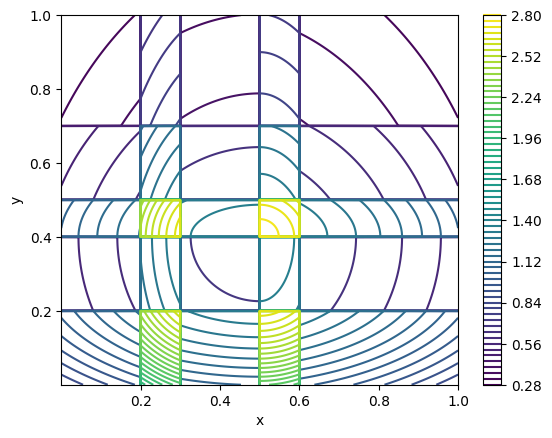

In [7]:
#testing plot of h (not optimised)

xs, ys = torch.linspace(1e-10, 1, 1000), torch.linspace(1e-10, 1, 1000)
X, Y = torch.meshgrid(xs, ys, indexing='ij')
points = torch.stack([X.flatten(), Y.flatten()], dim=0)
print(points.shape)
h_test = h(points, params)
print(h_test.shape)
Z = h_test.view(1000, 1000)

plt.figure()
plt.contour(X, Y, Z, levels=75, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


This section checks that the integral of the function is preserved under the transformation, and checks that the variances are sensible.

In [8]:
#check integral is preserved using (naive) MC

###REFERENCE VALUE: 0.851121###
N = 100000
#torch.manual_seed(42)
test_params = params

def MC_F(N):
  x, y = torch.rand(N), torch.rand(N)
  f_evals = f(x, y)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params):
  y1, y2 = torch.rand(N), torch.rand(N)
  y = torch.stack((y1, y2), dim=0)
  h_evals = h(y, params)
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H

F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} ± {alpha_F}')

H_est, alpha_H = MC_H(N, test_params)
print(f'H estimate = {H_est} ± {alpha_H}')


#can histogram results if needed

F estimate = 0.8509404063224792 ± 0.0002775304892566055
H estimate = 0.8496209383010864 ± 0.0016777977580204606


In [9]:
#check that variances are different in general
x_test, y_test = torch.rand(N), torch.rand(N)
y = torch.stack((x_test, y_test), dim=0)

f_var = torch.var(f(x_test, y_test))

h_for_var = h(y, test_params)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0077)
H variance: tensor(0.2865)


This section adds the use of unconstrained parameters by defining a softmax function to make varying K easier.  The training loop for minimising the variance is defined and a test plot of h is made for some optimised parameters.

In [10]:
#unconstrained parameters (makes varying K easier)
import torch.nn.functional
def u_to_y(u):
  zeros = torch.zeros((u.size(0), 1))
  u_ext = torch.cat([u, zeros], dim=1)
  w = torch.nn.functional.softmax(u_ext, dim=1)
  ys = torch.cumsum(w, dim=1)
  return ys[:, :-1]


In [21]:
#optimisation

#can use a training loop, variance is the loss function

def train_loop(x, K, epochs, lr):

  u_params = torch.zeros([2, K-1], requires_grad=True)
  optimiser = torch.optim.Adam([u_params], lr=lr)
  loss_values = torch.zeros(epochs)

  for epoch in range(epochs):
    params = u_to_y(u_params)
    g_ev = g(x, params)
    h_eval = h(g_ev, params)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    #if epoch % 10 == 0:
      #print(f"Epoch: {epoch} | Loss: {loss}")

  return loss, loss_values, u_to_y(u_params)

x_1d = torch.rand(1000)
x = torch.stack((x_1d, x_1d), dim=0)
test = train_loop(x, 8, 300, lr=0.02)
print(test[2])

tensor([[0.1122, 0.2349, 0.3655, 0.5000, 0.6346, 0.7654, 0.8882],
        [0.1122, 0.2349, 0.3655, 0.5000, 0.6346, 0.7654, 0.8882]],
       grad_fn=<SliceBackward0>)


torch.Size([2, 1000000])
torch.Size([1000000])


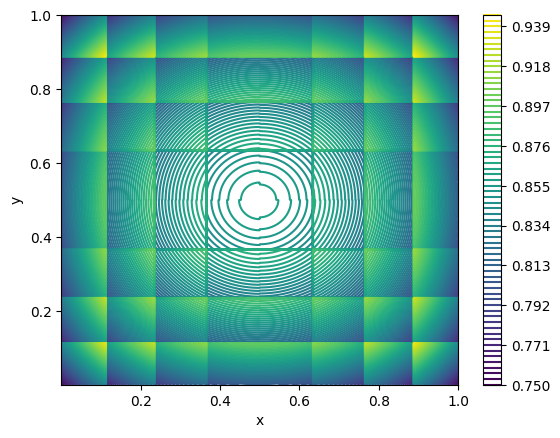

In [22]:
#plot of h with optimised parameters

y_params = test[2].detach()
xs, ys = torch.linspace(1e-10, 1, 1000), torch.linspace(1e-10, 1, 1000)
X, Y = torch.meshgrid(xs, ys, indexing='ij')
points = torch.stack([X.flatten(), Y.flatten()], dim=0)
print(points.shape)
h_test = h(points, y_params)
print(h_test.shape)
Z = h_test.view(1000, 1000)

plt.figure()
plt.contour(X, Y, Z, levels=75, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


This section is purely for visualisation/analysis tools - variation of loss with epoch, final loss vs number of bins, loss vs epoch for different learning rates, histogram of function evaluations for variance estimates.

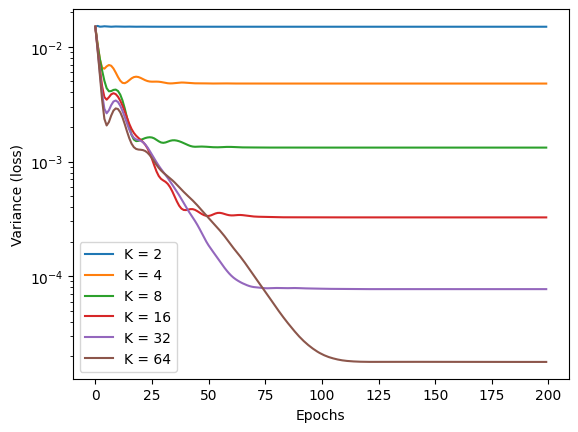

In [23]:
#loss vs epoch for different K

K_s = [2, 4, 8, 16, 32, 64]
epochs = 200
loss_values = torch.zeros((len(K_s), epochs))

for i in range(len(K_s)):
  loss_values[i] = train_loop(x, K_s[i], epochs, lr=0.02)[1]

#plotting
epochs_plot = torch.arange(epochs)
plt.figure()
for i in range(len(K_s)):
  plt.plot(epochs_plot, loss_values[i].detach().numpy(), label=f'K = {K_s[i]}')

plt.xlabel('Epochs')
plt.ylabel('Variance (loss)')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
#generate data

Ks = range(2, 33)
vars = torch.zeros(len(Ks))
i=0

for K in Ks:
  result = train_loop(x, K, 250)[0]
  vars[i] = result.reshape(1) # Reshape scalar to a 1D tensor
  i += 1

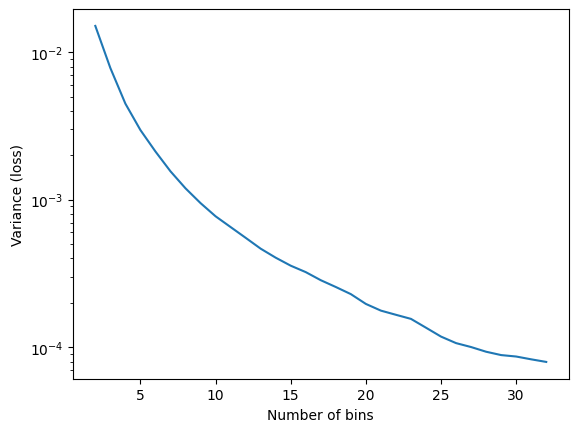

tensor([0.0151, 0.0078, 0.0045], grad_fn=<SliceBackward0>)
tensor(7.9494e-05, grad_fn=<SelectBackward0>)


In [ ]:
#plotting

plt.figure()
plt.plot(Ks, vars.detach().numpy()) # Detach and convert to numpy for plotting
plt.xlabel('Number of bins')
plt.ylabel('Variance (loss)')
plt.yscale('log')
plt.show()
print(vars[0:3])    #check for errors
print(vars[-1])     #check accuracy

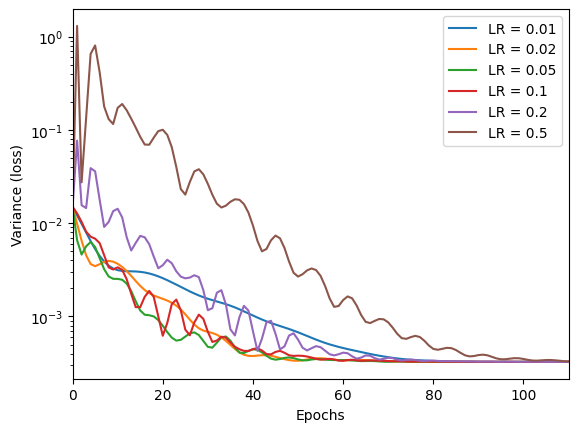

In [29]:
#loss vs epoch for different learning rates
K = 16
l_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
epochs=200
loss_values = torch.zeros((len(l_rates), epochs))

for i in range(len(l_rates)):
  loss_values[i] = train_loop(x, K, epochs, lr=l_rates[i])[1]

#plotting
epochs_plot = torch.arange(epochs)
plt.figure()
for i in range(len(l_rates)):
  plt.plot(epochs_plot, loss_values[i].detach().numpy(), label=f'LR = {l_rates[i]}')

plt.xlabel('Epochs')
plt.ylabel('Variance (loss)')
plt.xlim(0, 110)
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
#histogram of some number of function evaluations

